# Changes in Hue tuning

#### This notebook compares tuning curves constructed from 5 methods:
0. Neural responses to hue images
0. Natural images
    0. Average hue in RF
    0. Linear regression on hue in RF
    0. Nonlinear regression on hue in RF
    0. From querying a successful vgg model
    
    
### Import modules and load precomputed features and processed data

In [1]:
# compute
import numpy as np
import pandas as pd
import keras

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from tqdm import tqdm
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']

art_df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions')

df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')

nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

nat_features = pd.read_pickle('../02-preprocessed_data/M3/precomputed_nat_features')

### Neural responses to hue images

In [96]:
trials = Trials()

def prep_data_and_fit_neurons(df_neurons, df_data, model='XGB_poisson', session = 'art', 
                         nat_features = None, image_feature = 'hue.histogram', 
                         verbose = 0, plot=False, which_neurons = 'all',joint = False):
    """
    Fits neural data with specified model
    
    Returns a dataframe with a single column
    listing for each neuron a dictionary with 4 value/key pairs:
    'hue', 'spike_counts', 'predicted_spike_counts', 'pseudo_R2'
    
    Inputs:
    df_neurons = dataframe with neural data
    df_data = dataframe with all data. Must contain 'session_number' column
    
    Options:
    nat_features = precomputed natural features. Result of get_nat.features
                        Required when session = 'nat'.
    image_feature = {hue.histogram, hue.mean, vgg.l8, vgg.l7, vgg.l6, vgg.l5}
                        What feature to use for the natural images. 
                        Required when session = 'nat'.
                        
    model = what algorithm to feed to fit_cv 
    session = {'art', 'nat'} Which session type to fit to
    plot = {True, False} Whether to plot the fits
    verbose = {0,1,2} how much to print
    which_neurons = 'all', or list of indices of neurons to fit (in case you want just one, say)
    joint = whether to use non-images features too
    
    
    """
    assert session in ['art', 'nat']
    assert model in ['XGB_poisson', 'GLM_poisson','linear_regression','fitted_keras']
    if session is 'nat':
        assert nat_features is not None
        assert image_feature in \
             ['hue.histogram', 'hue.mean', 'vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5']
    if model is 'fitted_keras':
        assert image_feature in ['vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5'] and session is 'nat'
            
    if which_neurons is 'all':
        which_neurons = np.arange(len(df_neurons['name']))
    elif isinstance(which_neurons,int):
        which_neurons = [which_neurons]
        
    
    df_fits = pd.DataFrame(columns=[session+'_'+model+'_'+image_feature])
    which_session = session + '_sessions'
    
    # Compute feed forward features for plain hue image
    if session == 'nat':
        plain_hue = np.linspace(-np.pi, np.pi, 360)
        if image_feature in ['vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5']:
            
            # build model
            
            if image_feature == 'vgg.l8':
                vgg_model= V4.vgg_transfer_ari(n_pops=0)
                n_nodes = 1011
            elif image_feature == 'vgg.l7':
                vgg_model= V4.vgg_transfer_ari(n_pops=1)
                n_nodes = 4107
            elif image_feature == 'vgg.l6':
                vgg_model= V4.vgg_transfer_ari(n_pops=2)
                n_nodes = 4107
            elif image_feature == 'vgg.l5':
                vgg_model= V4.vgg_transfer_ari(n_pops=3)
                n_nodes = 25099
            
            
            Xplain = list()
            stimpath = '../V4pydata'
            for stim_id in range(360):
                imname = '/stimuli/M3/Hues/img%03d.jpg' % stim_id
                filename = stimpath + imname
                I = V4.load_and_preprocess_ari(filename)
                Xplain.append(np.squeeze(vgg_model.predict(I)))
            Xplain = np.array(Xplain)
            n_bins = Xplain.shape[1]
        elif image_feature == 'hue.histogram':
            # Define histograms of plain hue stimuli
            n_bins = 16
            Xplain = V4.onehothue(plain_hue, n_bins=n_bins)
        else:
            Xplain = plain_hue.reshape((360,1))
    
    ######### Get tuning curves for all neurons ###########

    for neuron_id, neuron_name in tqdm(enumerate(df_neurons['name'])):
        
        if neuron_id not in which_neurons:
            continue

        if verbose>0:
            print 'Running neuron ' + neuron_name


        ### Get proper X and Y data ~~~~~~~~~~~~~~~

        # Extract session numbers
        sessions_of_interest = df_neurons.loc[neuron_id][which_session]

        # Grab relevant data
        if session is 'art':
            df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest)]
            
            covariates =  ['predictors.hue', 
                           'predictors.col', 
                           'predictors.row', 
                           'predictors.hue_prev', 
                           'predictors.stim_dur', 
                           'predictors.off_to_onset_times']

            # Get covariates
            X = df_sessions_of_interest[covariates].values  
            # for plotting
            x_data = df_sessions_of_interest['predictors.hue'].values

            
        else:  # get natural feature
            df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest) & \
                                             df_data.index.isin(nat_features['accepted_indices'])]
            #-----------------
            # Get covariates
            #-----------------
            # Select a df of interest
            indices_of_interest = np.array(df_sessions_of_interest.index)
            nat_features_of_interest = \
                nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]

            # Convert everything to array

            n_samples = len(nat_features_of_interest)

            # Image features
            try: n_features = len(nat_features_of_interest['image_features']\
                             [nat_features_of_interest.index[0]][image_feature])
            except TypeError: # bad practice: assuming all errors will be for same reason. 

                n_features = 1

                    
            image_features_array = np.zeros((n_samples, n_features))
            image_features_list = [nat_features_of_interest['image_features'][k][image_feature] \
                                   for k in nat_features_of_interest.index]
            for k in range(n_samples):
                image_features_array[k, :] = image_features_list[k]

            # Non-image features
            n_features = np.shape(nat_features_of_interest['non_image_features']\
                                  [nat_features_of_interest.index[0]].values)[0]
            non_image_features_array = np.zeros((n_samples, n_features))
            non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                                   for k in nat_features_of_interest.index]
            for k in range(n_samples):
                non_image_features_array[k, :] = non_image_features_list[k]
                
            # for plotting
                            # remember we're plotting as a function of HUE MEAN
            x_data = np.array([nat_features_of_interest['image_features'][k]['hue.mean'] \
                      for k in nat_features_of_interest.index])

            # Concatenate
            if joint:
                X = np.concatenate((image_features_array, 
                                   non_image_features_array), 
                                  axis=1)
            else:
                X = image_features_array



        # Labels and number of folds for stratified CV
        labels = df_sessions_of_interest['session.number']
        n_cv = np.size(np.unique(sessions_of_interest))
        labels = [] if n_cv == 1 else labels
        n_cv = 10 if n_cv == 1 else n_cv

        # Get spike counts
        Y = df_sessions_of_interest[neuron_name].values
        
 
        
        #### Fit models ~~~~~~~~~~~~~~~~~
        
        if model is not 'fitted_keras':   
            my_model = None # for tinkering
            Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv, epochs=50,batch_size=128,
                                      algorithm= model,model = my_model,
                                      verbose=verbose)
        ### Get tuning curves
        if session is 'nat':
            # Fit the  model
            if model == 'fitted_keras':
                model_instance = V4.keras_GLM(n_nodes, 100)
                model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                           +str(neuron_id)+'_'+neuron_name+'_l6_joint')
            else:
                model_instance = V4.fit(X, Y, algorithm=model,epochs=50,batch_size=128,)
            
            ### Predict on plain hue stimuli ###
            # adding random noise to make up non-image features
            if joint:
                Xplain_augment = np.concatenate((Xplain, 
                                     X[np.random.randint(0, X.shape[0], Xplain.shape[0]), n_bins:]), 
                                    axis=1)
            else:
                Xplain_augment = Xplain
            
                
            if model == 'XGB_poisson':
                Yplain_hat = model_instance.predict(xgb.DMatrix(Xplain_augment))
            else:
                Yplain_hat = model_instance.predict(Xplain_augment)

        
        # plot responses. for natural images, it's response to images vs. average hue of image
        if plot:
            y_data = Y
            xlabel = 'hue'
            V4.plot_xy(x_data=x_data, y_data=y_data,
                       y_model=Yt_hat,
                       lowess_frac=0.5, xlabel=xlabel, model_name=model, 
                       x_jitter_level=0., y_jitter_level=0.5, title = 'max')
            #plt.title((X[np.argmax(Yt_hat)]*180/np.pi)[0])
            #plt.ylim([0,4])
            plt.show()
            
            
        temp = dict()
        temp['hue'] = x_data
        temp['spike_counts'] = Y
        
        if model is not 'fitted_keras':
            temp['predicted_spike_counts'] = np.squeeze(Yt_hat)
            temp['pseudo_R2'] = pseudo_R2
                     
        if session is 'nat':
            temp['plain_hue'] = plain_hue
            temp['plain_predicted_spike_counts'] = np.squeeze(Yplain_hat)
        
        df_fits.loc[neuron_id] = [temp]
        
    return df_fits

In [101]:
art_XGB = prep_data_and_fit_neurons(df_neurons, art_df, session = 'art',  
                          verbose = 0, plot=False, which_neurons = 'all',joint=False)

90it [00:16,  7.75it/s]


In [56]:
nat_vggl6 = prep_data_and_fit_neurons(df_neurons, nat_df, model='fitted_keras', session = 'nat', 
                          nat_features = nat_features, image_feature = 'vgg.l6', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=False)

90it [01:14,  1.64it/s]


In [57]:
nat_hist = prep_data_and_fit_neurons(df_neurons, nat_df, model='XGB_poisson', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.histogram', 
                          verbose = 0, plot=False, which_neurons = 'all',,joint=False)

90it [02:53,  1.42s/it]


In [97]:
nat_avg = prep_data_and_fit_neurons(df_neurons, nat_df, model='XGB_poisson', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.mean', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=False)

90it [24:45, 14.98s/it]


In [102]:
new_results_all = pd.concat([nat_avg,nat_hist,nat_vggl6,art_XGB],axis=1)
new_results_all.head()

nat_XGB_poisson_hue.mean  \
0  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   
1  {u'hue': [-2.35624170303, -1.21477484703, -1.6...   
2  {u'hue': [-0.89925122261, -0.840216875076, -0....   
3  {u'hue': [2.06351828575, 2.44149160385, 2.5039...   
4  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   

                                     nat_XGB_poisson  \
0  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   
1  {u'hue': [-2.35624170303, -1.21477484703, -1.6...   
2  {u'hue': [-0.89925122261, -0.840216875076, -0....   
3  {u'hue': [2.06351828575, 2.44149160385, 2.5039...   
4  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   

                                    nat_fitted_keras  \
0  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   
1  {u'hue': [-2.35624170303, -1.21477484703, -1.6...   
2  {u'hue': [-0.89925122261, -0.840216875076, -0....   
3  {u'hue': [2.06351828575, 2.44149160385, 2.5039...   
4  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   

                       art_XGB_poisson_hue.histogram  
0  {u'pseudo_R2': [0.175594644476, 0.106143275891...  
1  {u'pseudo_R2': [0.75848062617, 0.090662312172]...  
2  {u'pseudo_R2': [-0.494386818141, -0.3920071858...  
3  {u'pseudo_R2': [-0.11978161235, 0.227576191839...  
4  {u'pseudo_R2': [-0.172971566393, -0.4007662579...

In [58]:
#trials.best_trial
# {'dropout': [0],
#    'hidden_dim': [50],
#    'l1l2': [0.0011088222637138541],
#    'lr': [0.00016694354729608157]}

In [99]:
results_all = pd.read_pickle('../02-preprocessed_data/M3/results_all')

### Build a model that fits all neurons at once, sharing one layer of the dense net

'../05-figures_CCN/neuron-fit_4.pdf'

### Build the various tuning curves

In [278]:

def plot_fits(neuron_id):
    plt.figure(figsize=(8,8))
    neuron_name = df_neurons['name'][neuron_id]

    plot_xy(new_results_all['art_XGB_poisson_hue.histogram'][neuron_id]['hue'], 
            new_results_all['art_XGB_poisson_hue.histogram'][neuron_id]['spike_counts'],plot_points=False,colors=['k'],
           labels = ['Smoothed Data'])

    y_datas = [new_results_all[model_][neuron_id]['plain_predicted_spike_counts'] for model_ in\
              ['nat_XGB_poisson_hue.mean', 'nat_XGB_poisson', 'nat_fitted_keras']]

    plot_xy(new_results_all['nat_XGB_poisson_hue.mean'][neuron_id]['plain_hue'], 
            y_datas,xlabel='Hue',labels=['Mean hue','Hue hist','VGG'])
    #plt.title(str(neuron_id)+' '+neuron_name)
    plt.savefig('../05-figures_CCN/neuron-fit_{}.pdf'.format(str(neuron_id)), format='pdf')
    
    plt.show()


In [ ]:
plot_fits

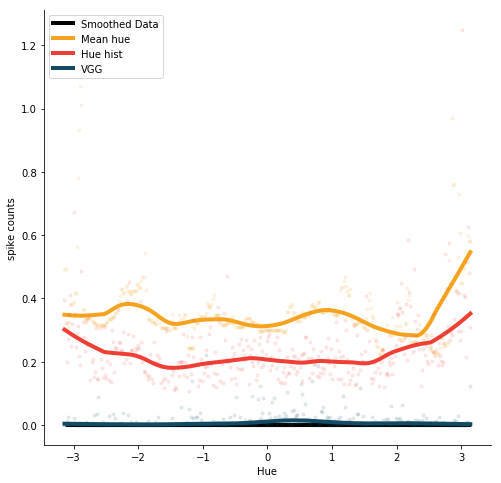

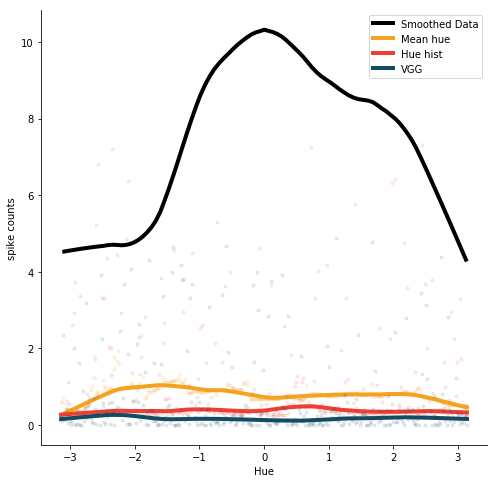

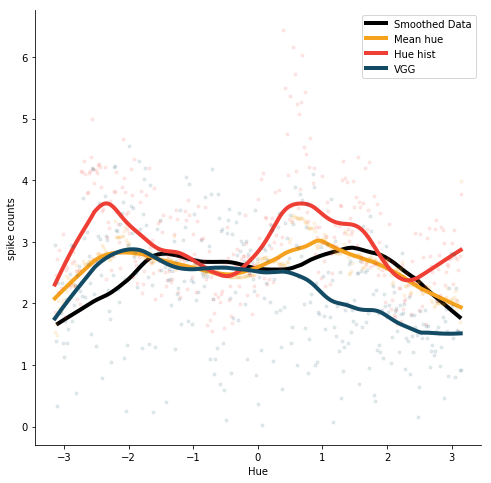

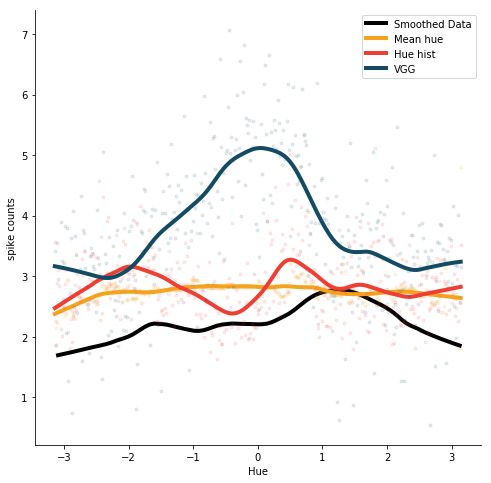

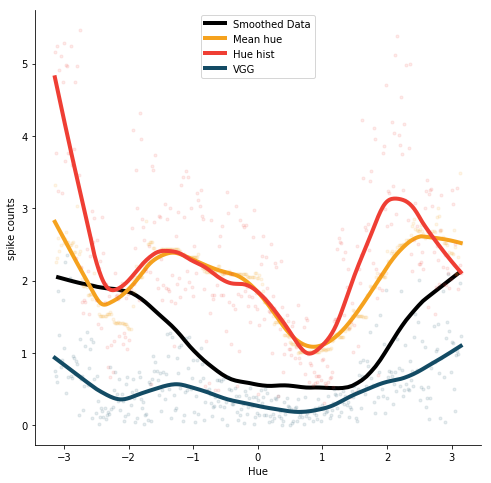

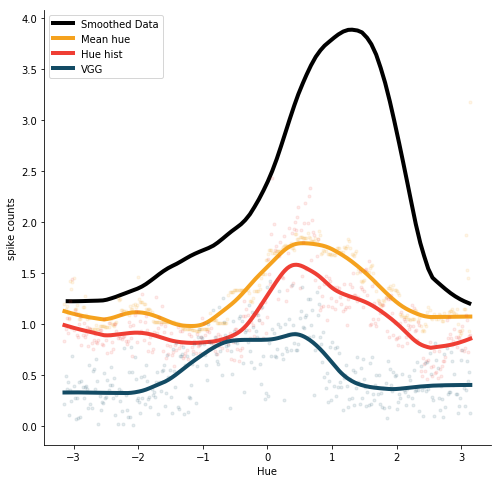

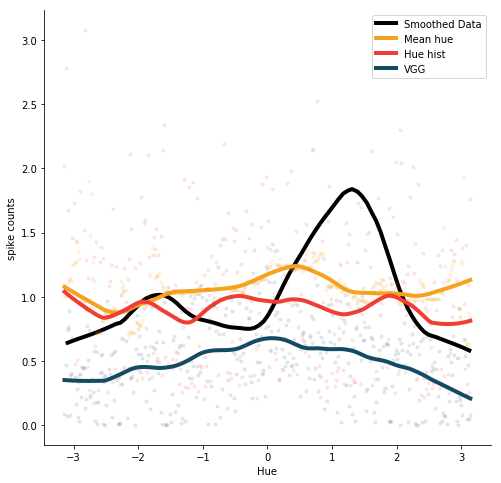

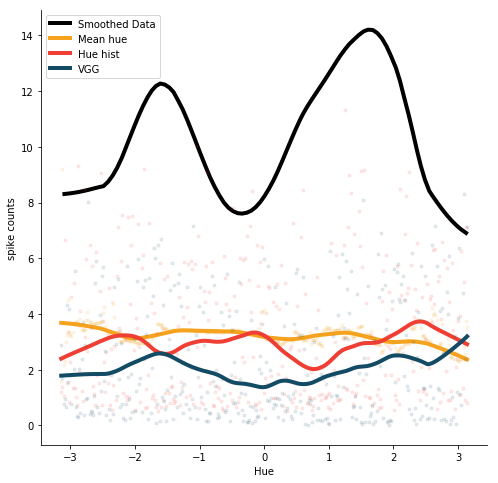

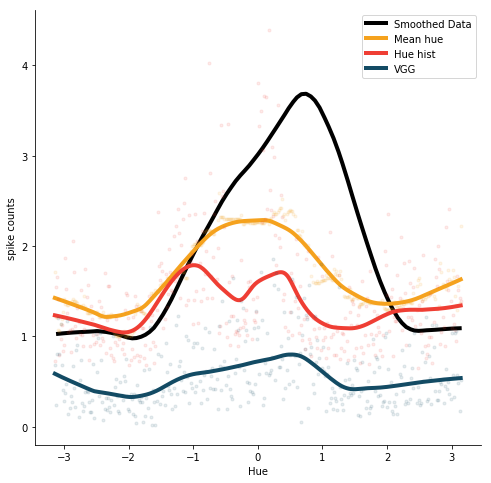

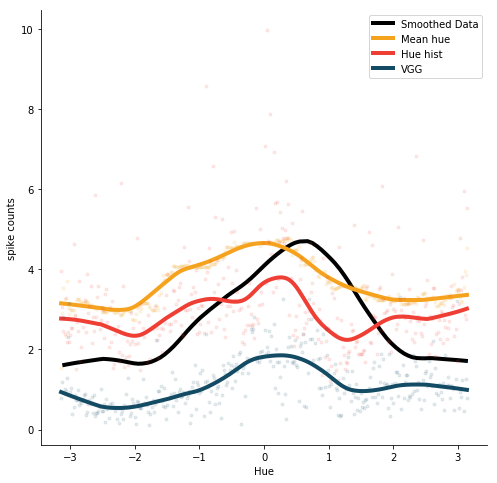

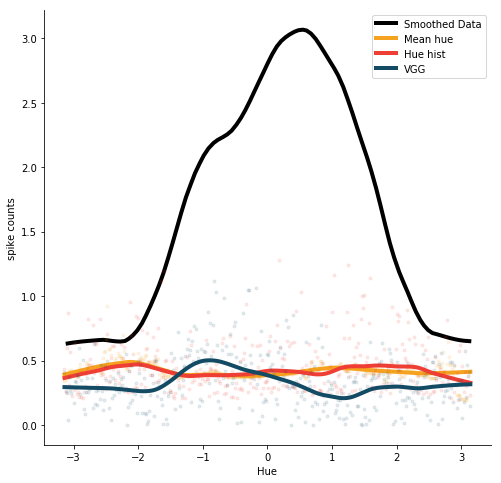

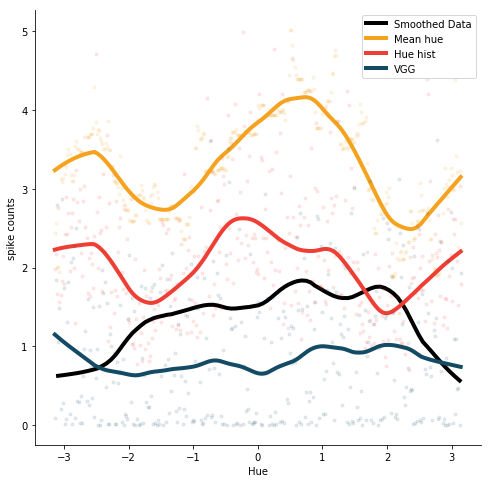

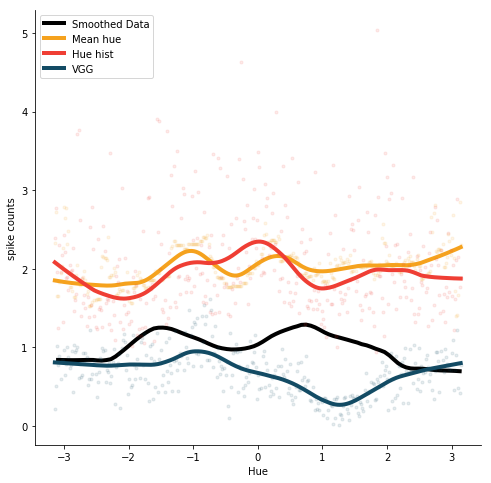

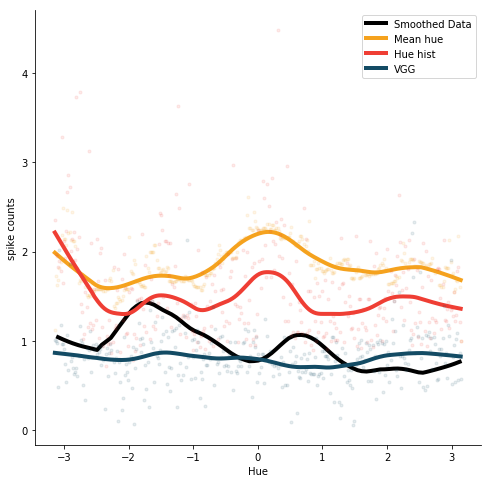

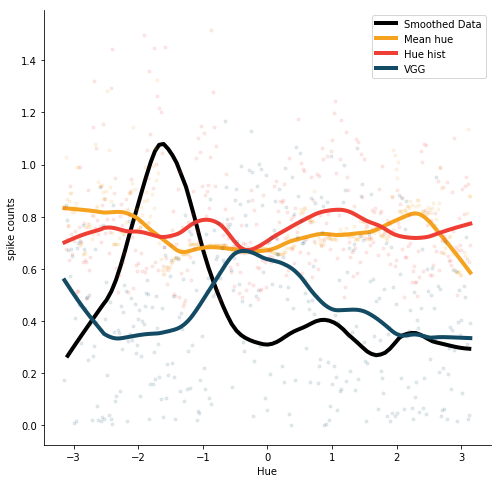

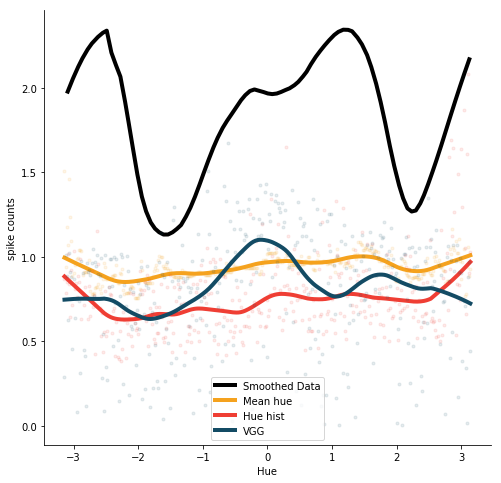

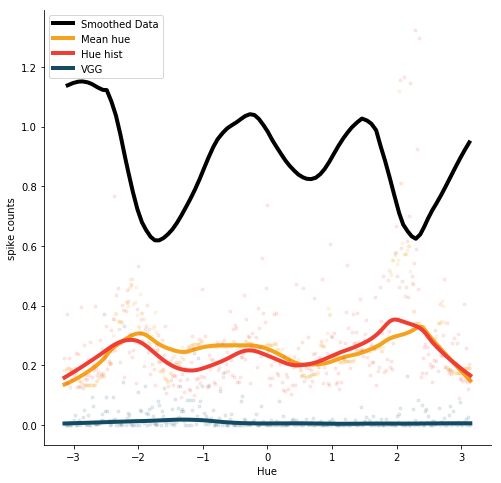

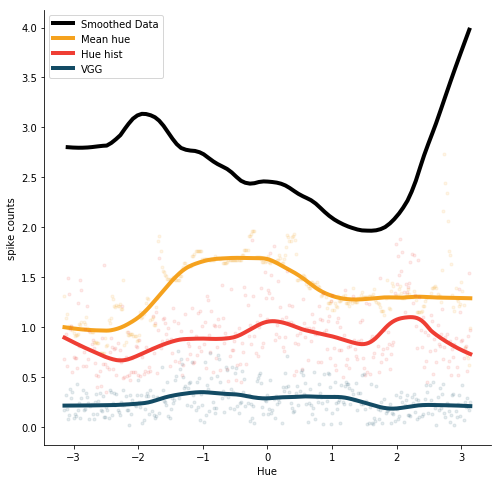

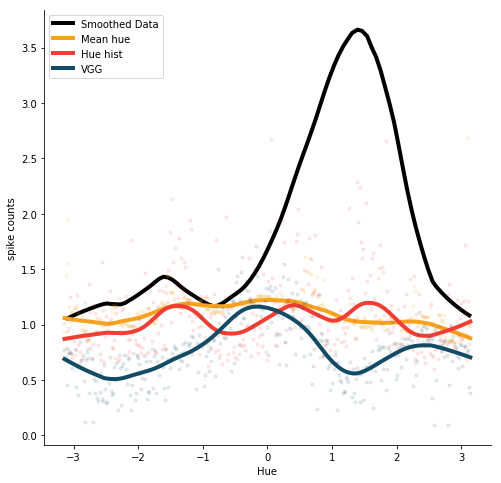

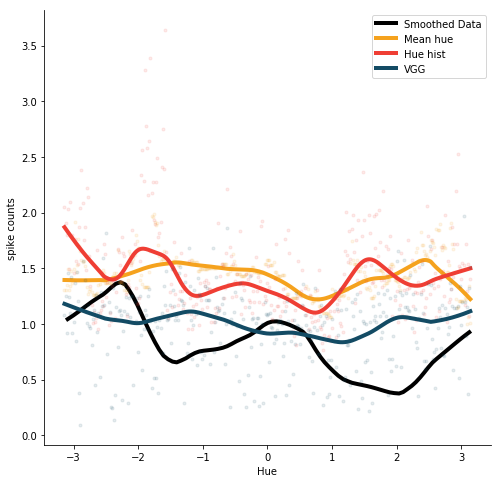

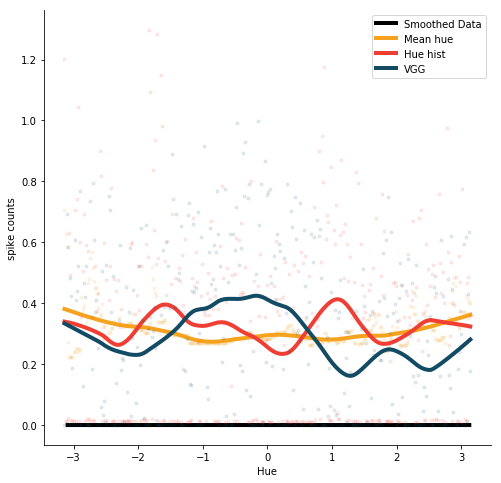

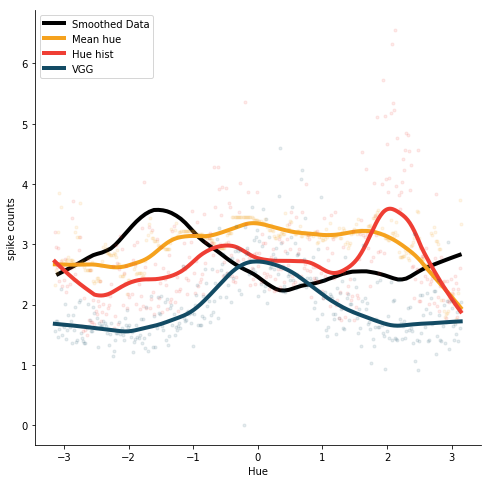

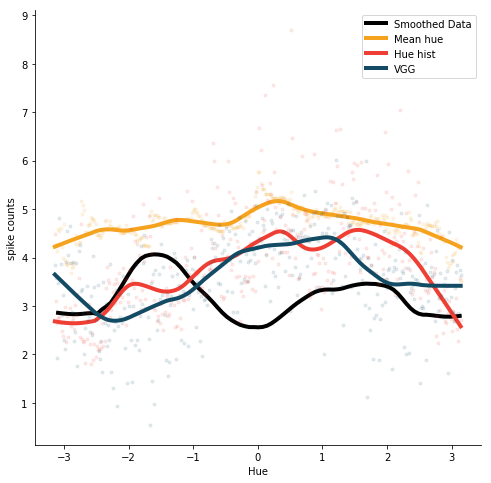

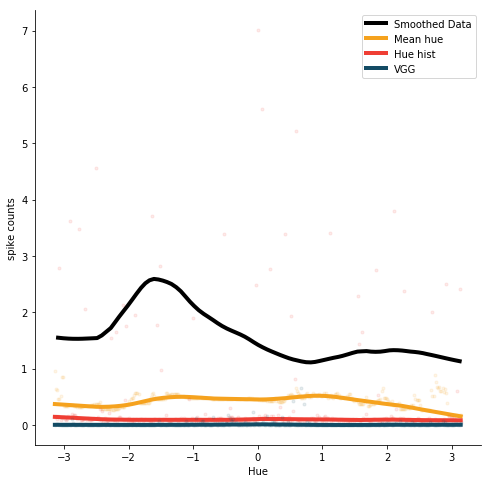

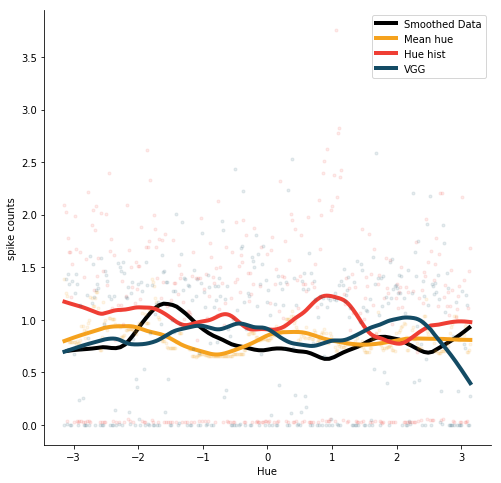

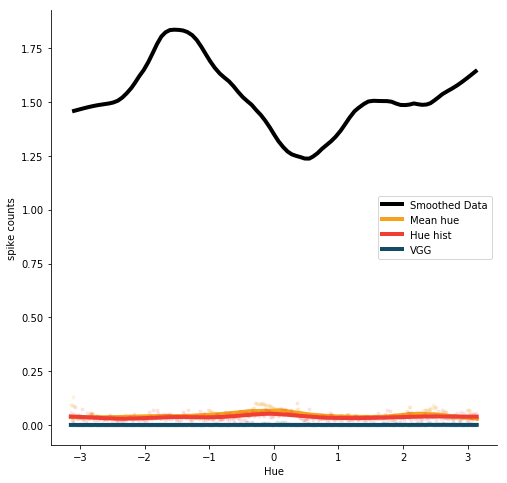

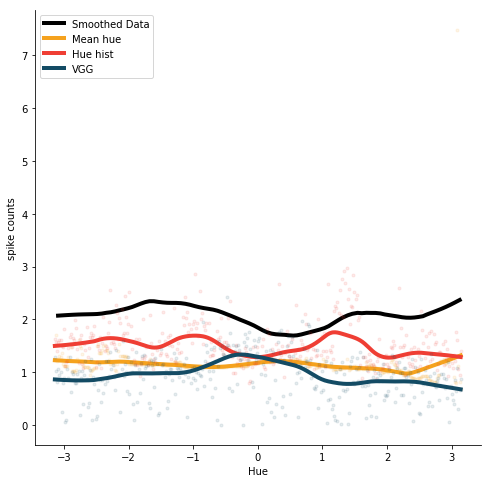

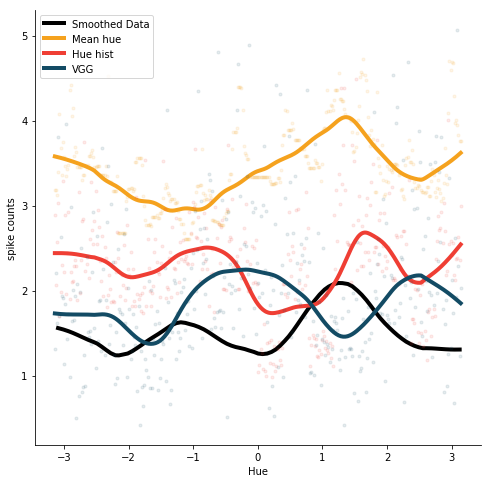

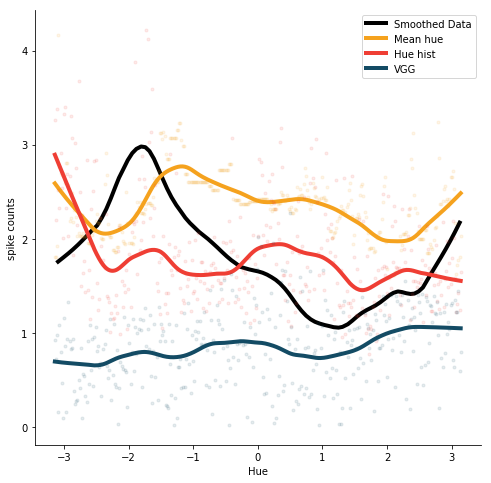

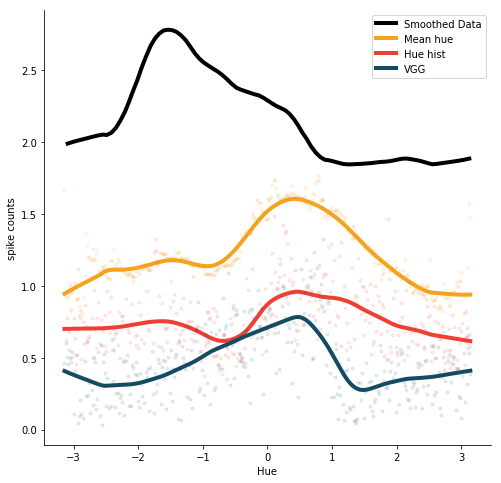

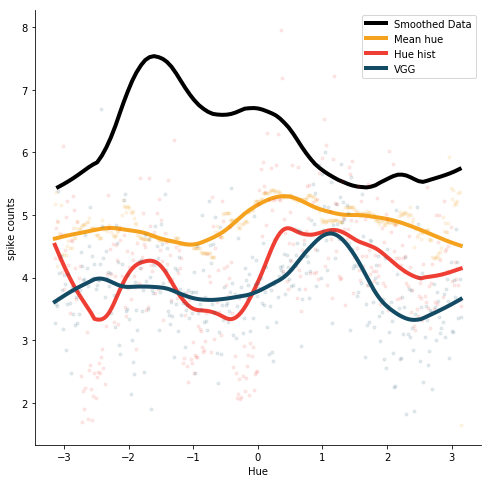

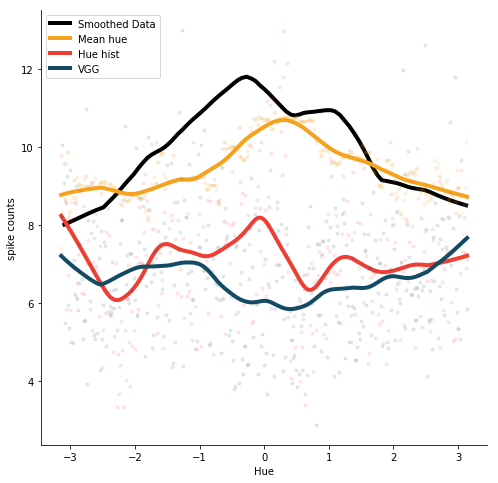

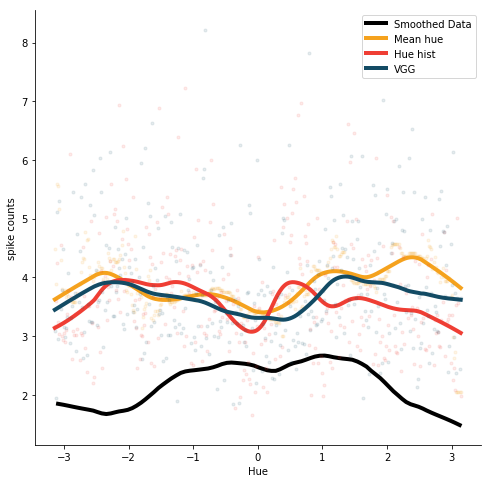

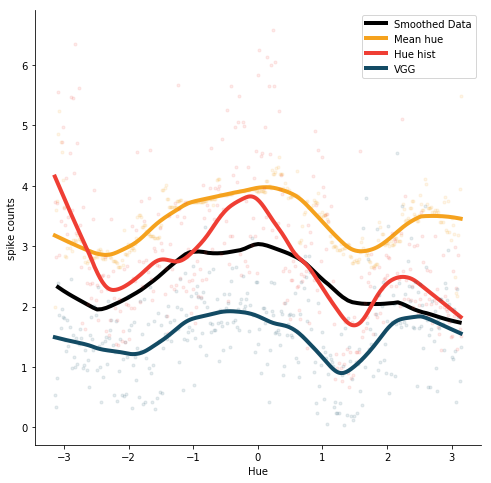

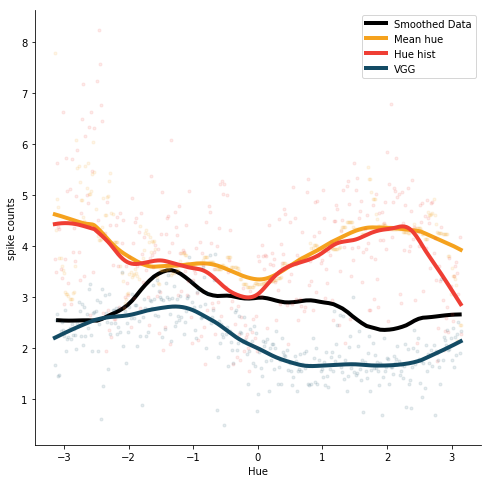

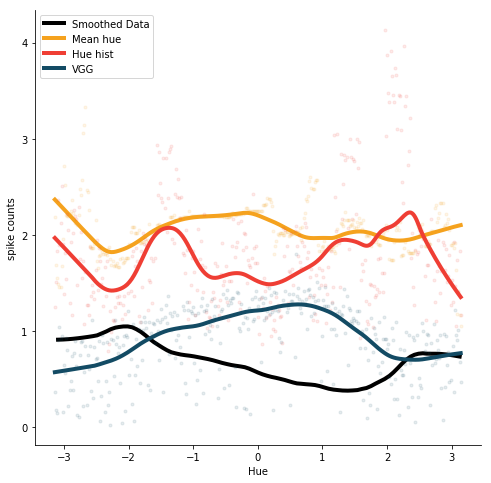

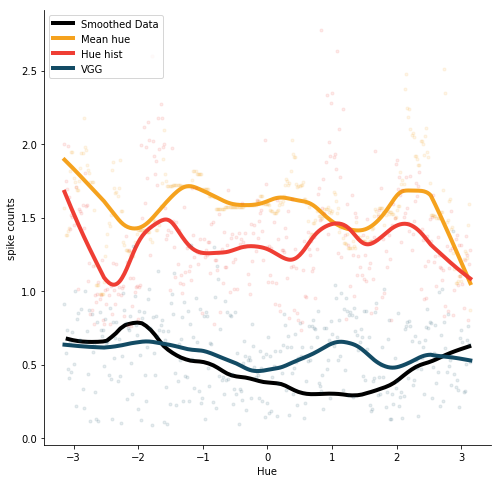

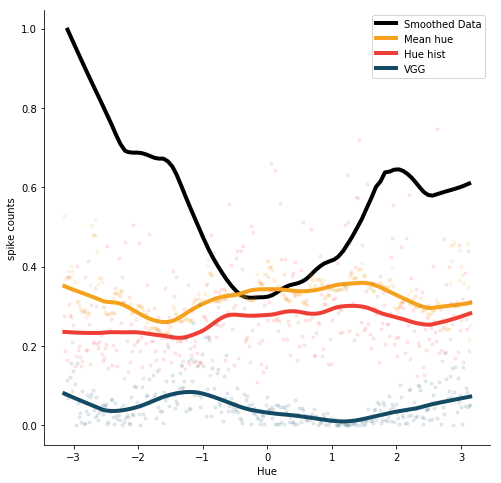

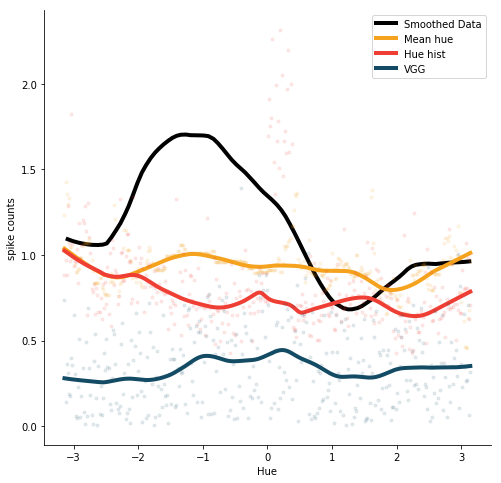

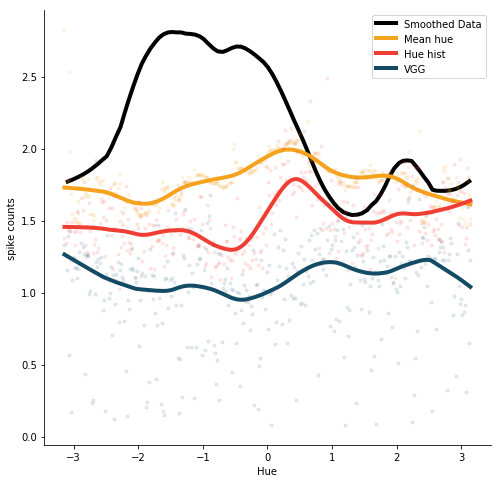

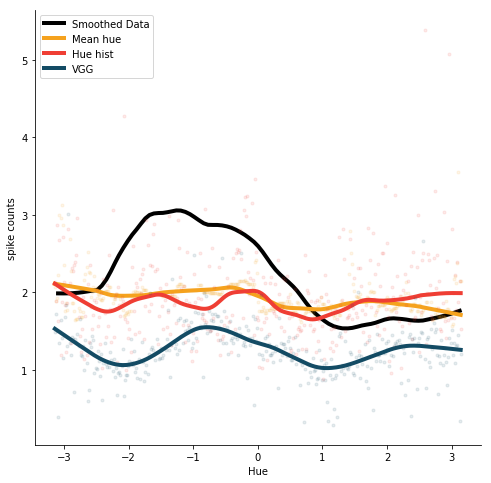

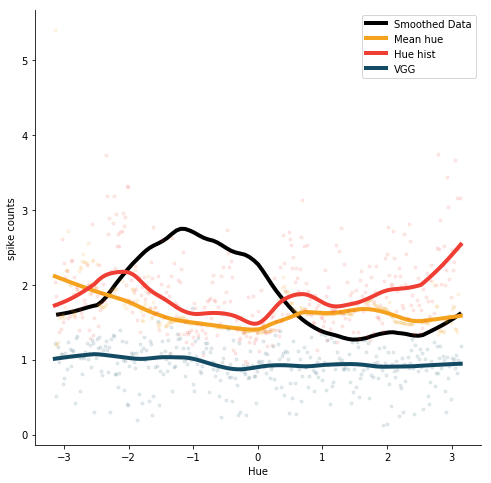

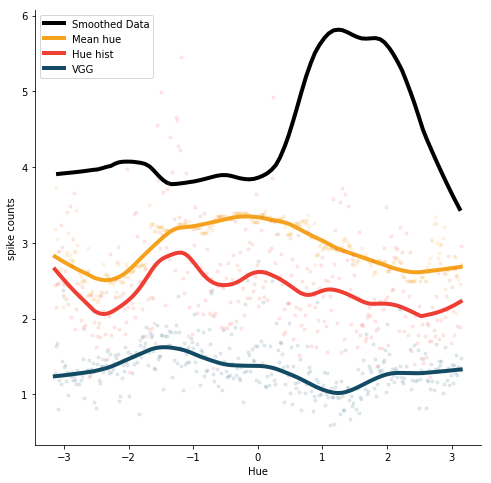

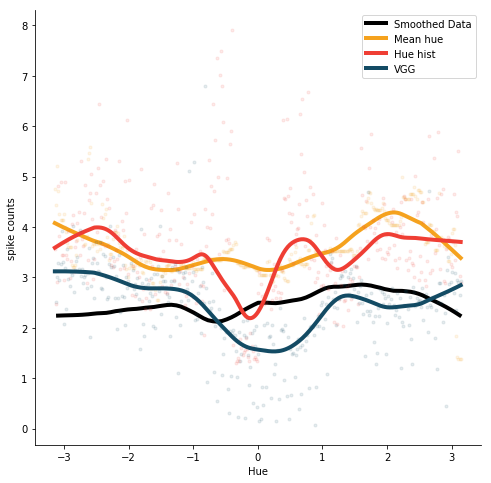

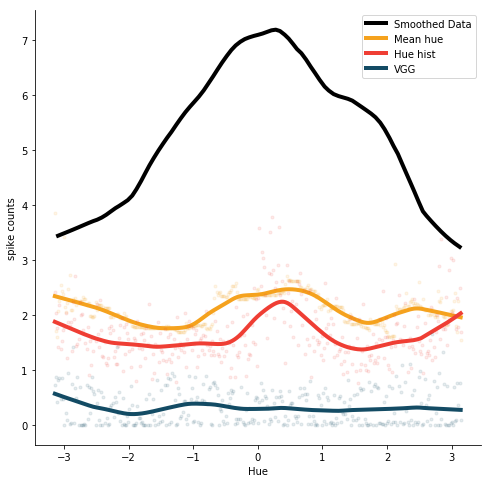

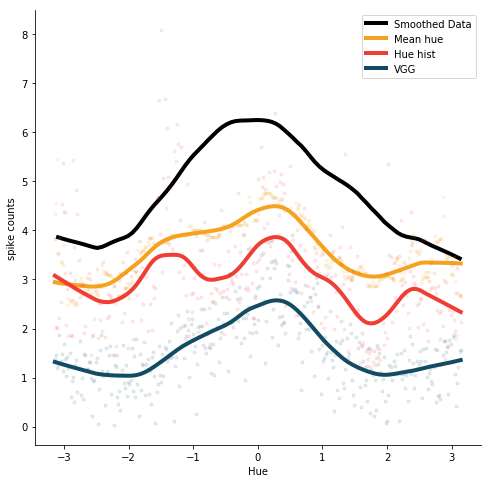

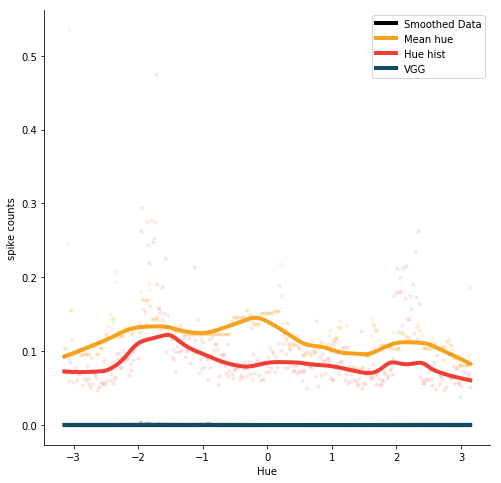

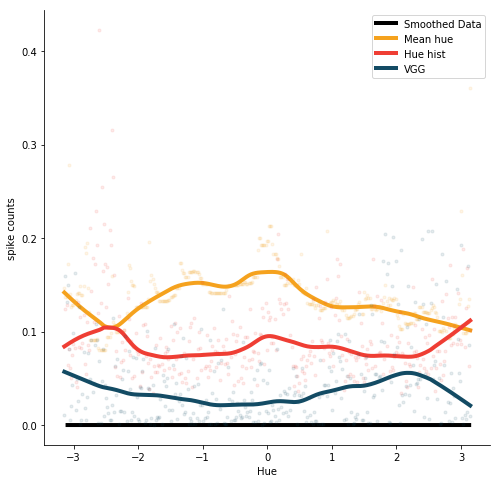

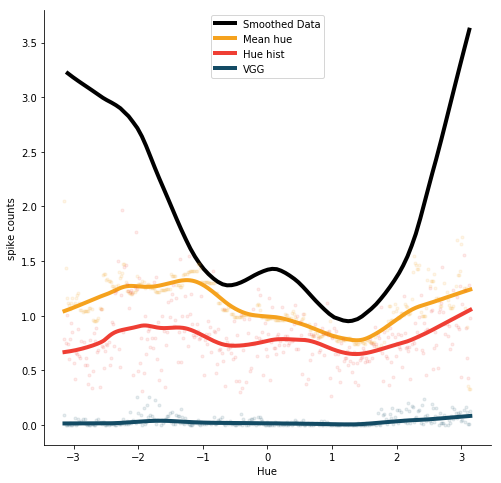

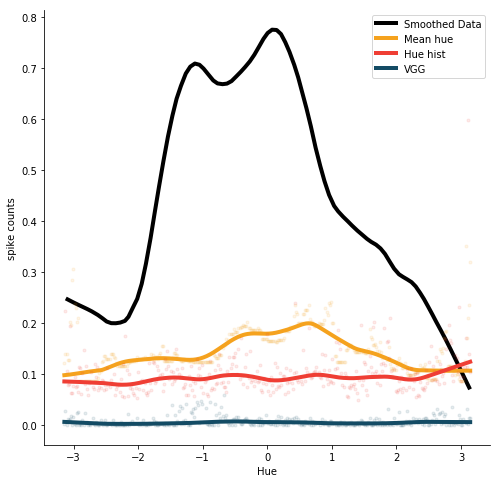

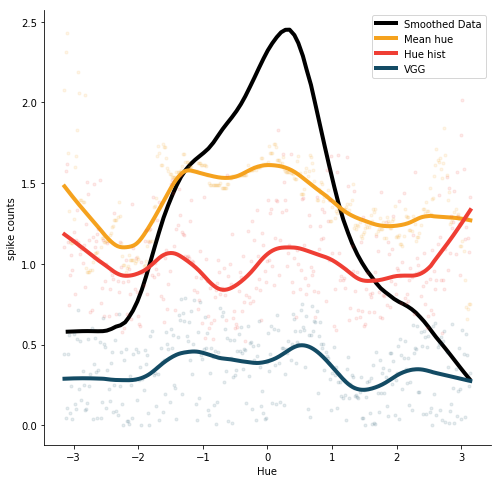

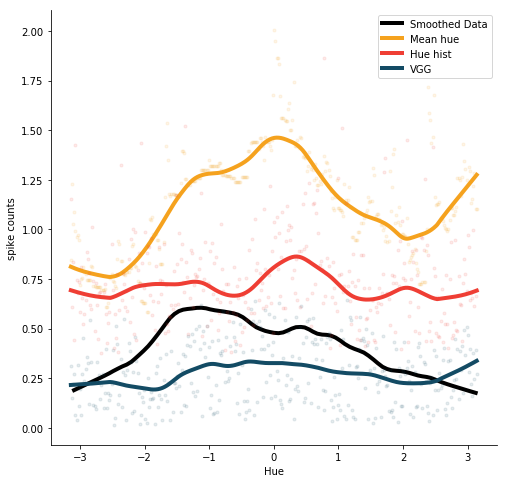

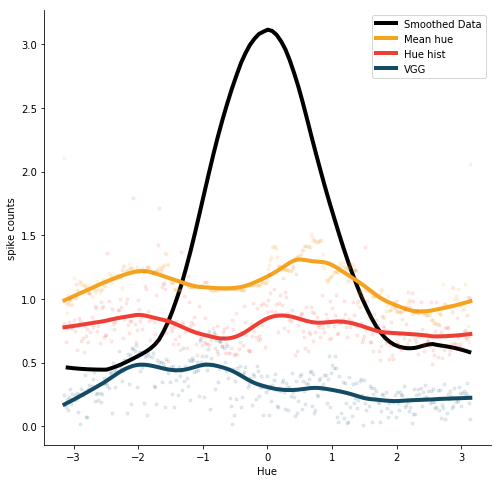

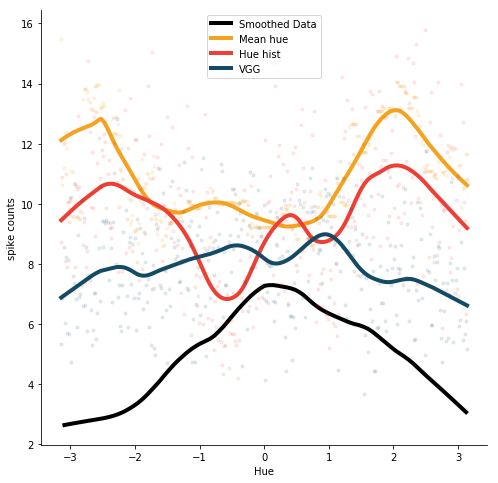

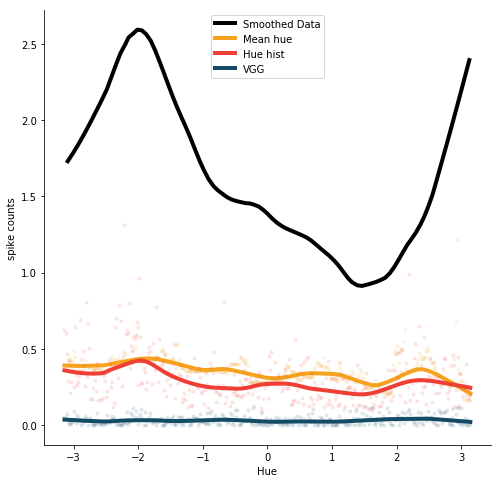

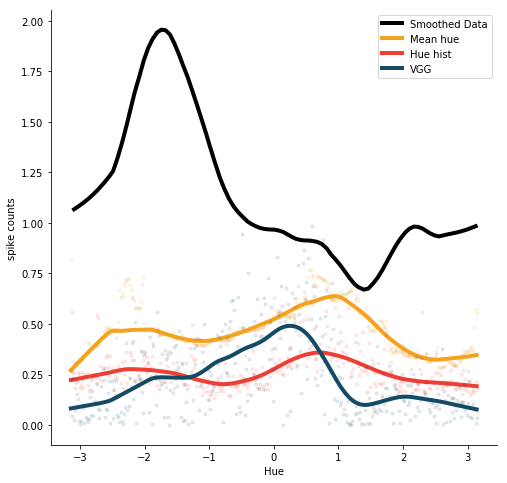

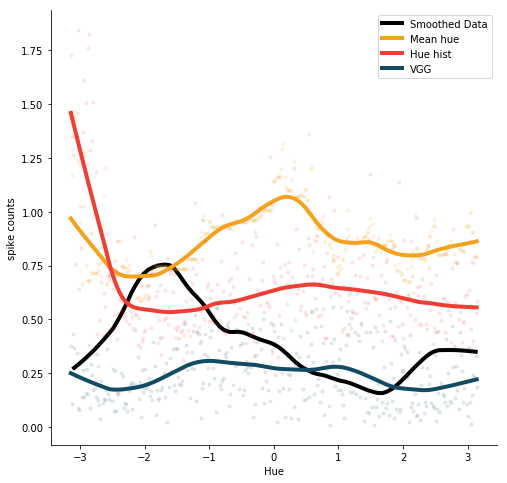

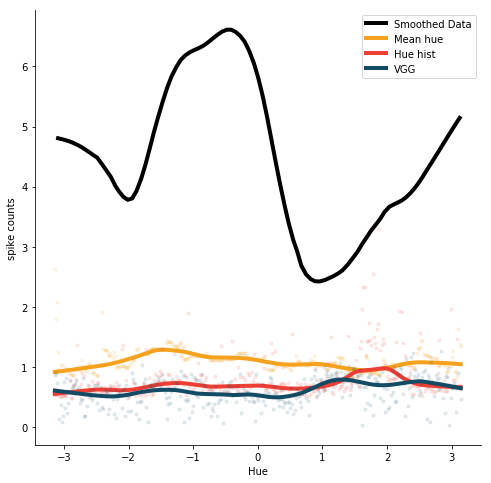

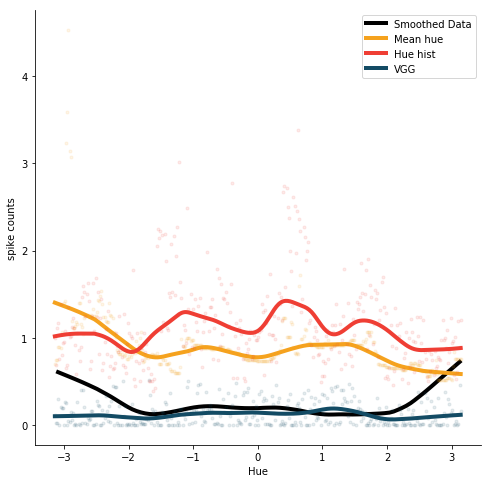

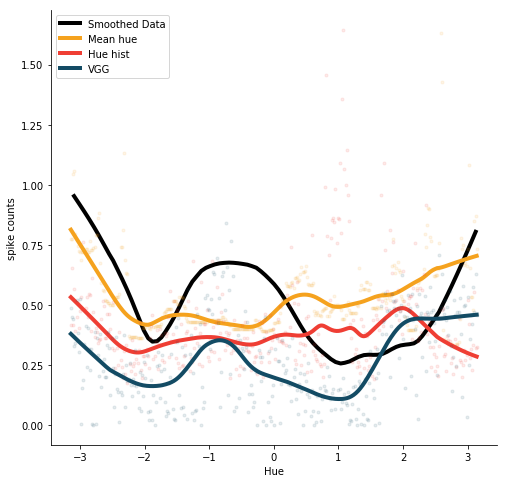

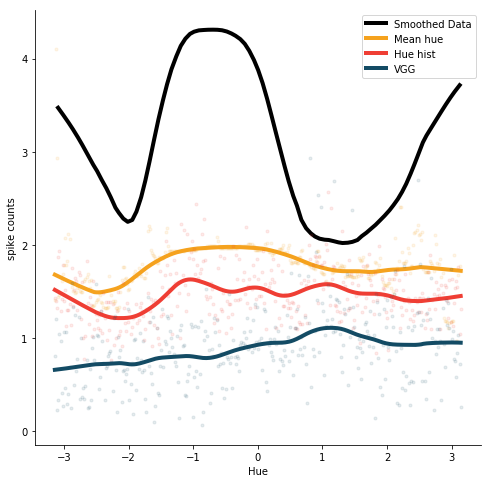

KeyboardInterrupt: 

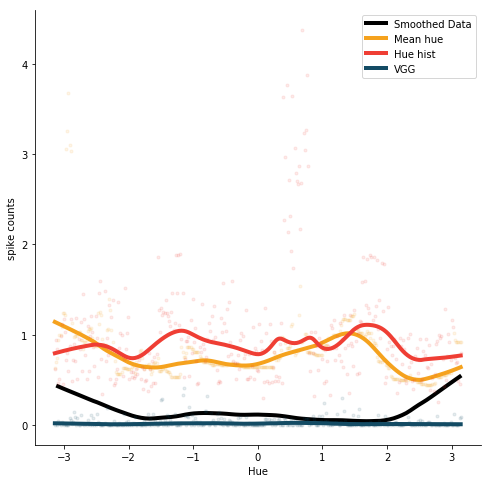

In [280]:
for i in range(len(df_neurons['name'])):
    plot_fits(i)

# Get correlation of tuning curves with artificial (fitted) tuning curves

In [227]:
nat_models = ['nat_XGB_poisson_hue.mean', 'nat_XGB_poisson', 'nat_fitted_keras']
art_model_name = 'art_XGB_poisson_hue.histogram'

art_nat_corrs = dict()
for nat_model in nat_models:
    art_nat_corrs[nat_model] = list()
    for neuron_id, neuron_name in enumerate(df_neurons['name']):

            # Fit a polynomial to the art tuning curve
        h = new_results_all[art_model_name][neuron_id]['hue'] * 180. / np.pi
        h[h < 0.] = 360. + h[h < 0.]

        f_poly = np.poly1d(np.polyfit(h, new_results_all[art_model_name][neuron_id]['predicted_spike_counts'], 5))        
        art_plain_hue = f_poly(new_results_all[nat_model][neuron_id]['plain_hue'])

        nat_predictions = np.squeeze(new_results_all[nat_model][neuron_id]['plain_predicted_spike_counts'])

        this_art_nat_corr = np.corrcoef(art_plain_hue, nat_predictions)[0,1]
        art_nat_corrs[nat_model].append(this_art_nat_corr)

nat_XGB_poisson_hue.mean
nat_XGB_poisson
nat_fitted_keras


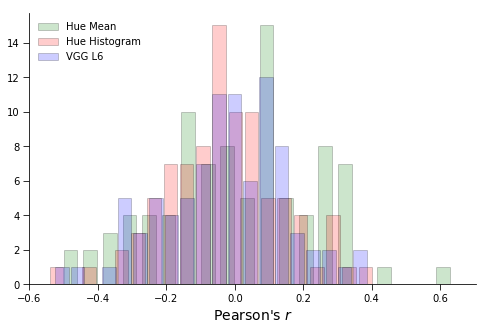

In [267]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
colors = ['g','r','b','y']

for i,nat_model in enumerate(nat_models):
    ax.hist(np.array(art_nat_corrs[nat_model]), 20, color=colors[i], alpha=0.2, edgecolor = 'k',width = .04)
    # ax.hist(art_syn2_corr, 20, color='r', alpha=0.2)
    # ax.hist(art_syn3_corr, 20, color='b', alpha=0.2)
    # ax.hist(art_syn4_corr, 20, color='y', alpha=0.2)
plt.legend(['Hue Mean', 'Hue Histogram', 'VGG L6',], loc='upper left', frameon=False)

plt.xlabel('Pearson\'s $r$', fontsize=14)
V4.simpleaxis(ax)
#ax.plot(np.arange(60), np.zeros(60), 'k--')
#plt.xlim([-1, 60])
#plt.xlabel('neuron', fontsize=14)
plt.savefig('../05-figures_CCN/hue_tune_corr_histogram.pdf', format='pdf')
plt.show()

Whereas the correlations among the models:

nat_XGB_poisson_hue.mean___nat_XGB_poisson
nat_XGB_poisson_hue.mean___nat_fitted_keras
nat_XGB_poisson___nat_fitted_keras


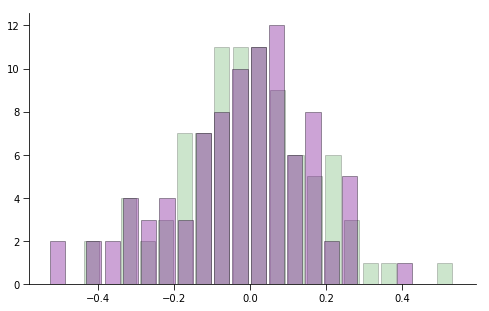

In [256]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)

nat_nat_corrs = dict()
i=0
for j,nat_model_1 in enumerate(nat_models):
    if j>1:
        continue
    for nat_model_2 in nat_models[(j+1):]:
        nat_nat_corrs[nat_model_1 + '_' + nat_model_2] = list()
        for neuron_id, neuron_name in enumerate(df_neurons['name']):
            nat_predictions_1 = np.squeeze(new_results_all[nat_model_1][neuron_id]['plain_predicted_spike_counts'])
            nat_predictions_2 = np.squeeze(new_results_all[nat_model_2][neuron_id]['plain_predicted_spike_counts'])
            
            this_nat_nat_corr = np.corrcoef(art_plain_hue, nat_predictions_2)[0,1]
            nat_nat_corrs[nat_model_1 + '_' + nat_model_2].append(this_nat_nat_corr)
            
        print nat_model_1 + '___' + nat_model_2
        ax.hist(np.array(nat_nat_corrs[nat_model_1 + '_' + nat_model_2])\
                , 20, color=colors[i], alpha=0.2, edgecolor = 'k',width = .04)
        i+=1
V4.simpleaxis(ax)     
plt.show()

^^ Why are the second two the same???

### Run same analysis for orientation

In [ ]:
ori_df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions_orientation')
# Correct for orientation angle > 180 deg.
ori_df['predictors.ori'] = np.where(ori_df['predictors.ori'] >= 180.0,
                                ori_df['predictors.ori'] - 180.0,
                                ori_df['predictors.ori'])
ori_df['predictors.ori_prev'] = np.where(ori_df['predictors.ori_prev'] >= 180.0,
                                     ori_df['predictors.ori_prev'] - 180.0,
                                     ori_df['predictors.ori_prev'])

In [ ]:
plt.figure(figsize=(12,5))

# L6
ax = plt.subplot(121)
V4.simpleaxis(ax)

syn_model1_name = 'vggl6_model'
for neuron_id, neuron_name in enumerate(df_results_all['name']):
    mu_x = np.mean(nat_hue_hist[neuron_id]['pseudo_R2'])
    sigma_x = np.std(nat_hue_hist[neuron_id]['pseudo_R2'])
    
    mu_y = np.mean(nat_100l_glm[neuron_id]['pseudo_R2'])
    sigma_y = np.std(nat_100l_glm[neuron_id]['pseudo_R2'])
    
    if (mu_y - 2. * sigma_y > 0.):
        ax.errorbar(x=mu_x, y=mu_y, 
                    xerr=sigma_x, yerr=sigma_y,
                    fmt='ko', alpha=0.2)

ax.plot(np.linspace(-2., 2., 10), np.linspace(-2., 2., 10), 'k--')
ax.plot(np.linspace(-2., 2., 10), 2. * np.linspace(-2., 2., 10), 'k--')
ax.plot(np.linspace(-2., 2., 10), 5. * np.linspace(-2., 2., 10), 'k--')
ax.plot(np.linspace(-2., 2., 10), np.zeros(10), 'k--')
ax.plot(np.zeros(10), np.linspace(-2., 2., 10), 'k--')
ax.axis([-0.2, 1.2, -0.2, 1.2])
plt.xlabel('histogram [pseudo-$R^2$]', fontsize=12)
plt.ylabel('VGG16 L6 [pseudo-$R^2$]', fontsize=12)

In [186]:

def plot_xy(x_data=None, y_datas=None, 
            lowess_frac = 0.2,
            xlabel='variable',
            model_name='hue',
            x_jitter_level=0, y_jitter_level=0.5,
            semilogx=False,
            model_alpha=0.1,
            colors=['#F5A21E', '#EF3E34', '#134B64',  '#02A68E', '#FF07CD'],
            data_ms = 10, title = None, labels = None,
            plot_points=True):
    
    if not isinstance(y_datas,list):
        y_datas = [y_datas]
    
    if labels is None:
        labels = ['_']*len(y_datas)

    # User lowess smoothing to smooth data and model
    lowess = V4.sm.nonparametric.lowess
    smoothed_data = [lowess(np.squeeze(y_d), x_data, frac=lowess_frac) for y_d in y_datas]

    # Add jitter to both axes
    x_jitter = x_jitter_level * np.random.rand(np.size(x_data))
    y_jitter = y_jitter_level * np.random.rand(np.size(y_datas[0]))

    # Display
    if semilogx:
        for i,y_data in enumerate(y_datas):
            if plot_points:
                plt.semilogx(x_data + x_jitter,
                         y_data + y_jitter,
                         '.', alpha=model_alpha, color = colors[i],
                         ms=data_ms)

       

            plt.semilogx(smoothed_data[i][:, 0],
                         smoothed_data[i][:, 1],
                         color=colors[i], lw=4)


    else:
        for i,y_data in enumerate(y_datas):
            if plot_points:
                plt.plot(x_data + x_jitter,
                     y_data,
                     '.', color=colors[i],
                     alpha=model_alpha,label='_')


            plt.plot(smoothed_data[i][:,0],
                     smoothed_data[i][:,1],
                     color=colors[i], lw=4,label=labels[i])

    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    plt.xlabel(xlabel)
    plt.ylabel('spike counts')
    #plt.legend(['data', 'model %s' % model_name, 'smoothed data', 'smoothed model'],
    #           frameon=False)
    
    if title == 'max':
        model_max = smoothed_data[np.argmax(smoothed_model[:,1]),0]
        data_max = smoothed_data[np.argmax(smoothed_data[:,1]),0]
        title = 'Model {0:.2f} ; Data {1:.2f}'.format(model_max,data_max)
    
        plt.title(title)
        
    plt.legend()

In [ ]:
       
        ### Hyperparameter optimization
        
#         space4rf = {
#             'learning_rate': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
#             'l1l2': hp.loguniform('l1l2', np.log(1e-3),np.log(1e-1)),
#             'hidden_dim': hp.choice('hidden_dim', list(np.arange(100))),
#             'dropout': hp.choice('dropout' , [0.1,0.2,0.3,0.4,0.5]),
#         }

        
        
#         def keras_GLM( hidden_dim, learning_rate=0.0001,l1l2 = 0.01,dropout = 0.5):
#             model = keras.models.Sequential()
#             input_dim = X.shape[1]
#             # Add a dense exponential layer with hidden_dim outputs
#             if hidden_dim > 0:
#                 model.add(keras.layers.Dense(hidden_dim, input_shape=(input_dim,), \
#                                 kernel_initializer='glorot_normal', activation='relu'))
#                 model.add(keras.layers.Dropout(dropout))

#                 # Add a dense exponential layer with 1 output
#                 model.add(keras.layers.Dense(1, kernel_initializer='glorot_normal', activation='softplus', \
#                                 activity_regularizer=keras.regularizers.l1_l2(l1l2)))

#             else:
#                 # Add a dense exponential layer with 1 output
#                 model.add(keras.layers.Dense(1, input_shape=(input_dim,),\
#                                 kernel_initializer='glorot_normal', activation='softplus', \
#                                 activity_regularizer=keras.regularizers.l1_l2(l1l2)))

#             optim = keras.optimizers.Nadam(lr=learning_rate, clipnorm=0.5)

#             model.compile(loss='poisson', optimizer=optim)
#             return model
#         def fnc(params):
            
#             my_model = keras_GLM(**params)
            
#             Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
#                                       stratify_by_labels=labels,
#                                       n_cv=n_cv, epochs=50,batch_size=128,
#                                       algorithm= model,model = my_model,
#                                       verbose=1)
            
#             return -np.mean(pseudo_R2)

#         hyperoptBest = fmin(fnc, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)

### Check if mean hue is calculated right

### Rigorously characterize the response to flat hue == model fit to neural response to flat hue

### Things to cluster by

in images where the hue is nearly even, is there a difference there? would be evidence of top down or attentional effects